In [24]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

In [25]:
from sklearn.preprocessing import QuantileTransformer

def remove_disparate_impact_global(df, features, protected_attr, repair_level=0.5):
    df = df.copy()
    
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan

        # Global reference distribution
        qt_global = QuantileTransformer(output_distribution='normal')
        global_transformed = qt_global.fit_transform(df[[feature]]).flatten()

        df[f"{feature}_quantile"] = global_transformed  # for interpolation

        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            original = df.loc[group_mask, feature]
            transformed = df.loc[group_mask, f"{feature}_quantile"]
            repaired = (1 - repair_level) * original + repair_level * transformed
            df.loc[group_mask, repaired_col] = repaired

        df.drop(columns=[f"{feature}_quantile"], inplace=True)

    return df


In [26]:
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import numpy as np

def remove_disparate_impact(df, features, protected_attr, repair_level=0.5):

    df = df.copy()
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan
        
        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            group_values = df.loc[group_mask, feature].values.reshape(-1, 1)
            
            qt = QuantileTransformer(output_distribution='normal')
            transformed = qt.fit_transform(group_values).flatten()
            
            original = df.loc[group_mask, feature]
            repaired = (1 - repair_level) * original + repair_level * transformed
            
            df.loc[group_mask, repaired_col] = repaired

    return df


In [27]:
df = pd.read_csv('complete_df_with_predictions.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [28]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])

In [29]:
race_mapping = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print(race_mapping)

{'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [30]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]

In [31]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [32]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

In [33]:
new_features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'race1_encoded_repaired', 'tier_repaired', 'fam_inc_repaired']

In [34]:
df_train_rw = df_train.copy()
df_train_rw['race1_encoded_repaired'] = remove_disparate_impact(df_train, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_train_rw['tier_repaired'] = remove_disparate_impact(df_train, ['tier'], 'tier')['tier_repaired']
df_train_rw['fam_inc_repaired'] = remove_disparate_impact(df_train, ['fam_inc'], 'fam_inc')['fam_inc_repaired']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (711). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (475). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local

In [35]:
X_train_rw = df_train_rw[new_features]
y_train_rw = df_train_rw[target]

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

param_grid = {
    'C': [0.01, 0.1, 1, 10], #normalization
    'class_weight': [{0: w0, 1: 1} for w0 in [5, 10, 20, 50, 100]] # we try penalizing more only class 0 mistakes
}

lr = LogisticRegression(max_iter=1000, solver='liblinear') 


fbeta_scorer = make_scorer(fbeta_score, beta=1.41, pos_label=0)
                               
grid_search = GridSearchCV(lr, param_grid, scoring=fbeta_scorer, cv=5, n_jobs=-1)

grid_search.fit(X_train_rw, y_train_rw)

lr_best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best Fbeta-score for class 0:", grid_search.best_score_)

Best parameters: {'C': 0.01, 'class_weight': {0: 10, 1: 1}}
Best Fbeta-score for class 0: 0.3915644442708744


In [37]:
# from sklearn.metrics import confusion_matrix, classification_report


# y_test_pred = lr_best_model.predict(X_test)

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

### on whole dataset

In [38]:
df_rw = df.copy()
df_rw['race1_encoded_repaired'] = remove_disparate_impact_global(df, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_rw['tier_repaired'] = remove_disparate_impact_global(df, ['tier'], 'tier')['tier_repaired']
df_rw['fam_inc_repaired'] = remove_disparate_impact_global(df, ['fam_inc'], 'fam_inc')['fam_inc_repaired']

In [39]:
df_rw

,zgpa,bar1_yr,bar2_yr,zfygpa,race1_white,race1_encoded,race1_other,grad,ID,ugpa,...,decile1,tier,Unnamed: 0,bar1,decile3,race1_black,parttime,race1_encoded_repaired,tier_repaired,fam_inc_repaired
0,1.88,7.0,94.0,1.33,True,4,False,1,2,3.5,...,10.0,4.0,0,1,10.0,False,0.0,4.599669,2.134592,5.099669
1,-0.57,7.0,94.0,-0.11,True,4,False,1,3,3.5,...,5.0,2.0,1,1,4.0,False,0.0,4.599669,0.245172,2.261769
2,-1.12,7.0,94.0,-0.64,True,4,False,1,36,3.5,...,3.0,3.0,2,1,2.0,False,0.0,4.599669,1.219336,-2.099669
3,-0.49,7.0,94.0,0.34,True,4,False,1,52,3.5,...,7.0,3.0,3,1,4.0,False,0.0,4.599669,1.219336,2.261769
4,0.76,7.0,94.0,1.02,True,4,False,1,55,3.5,...,9.0,5.0,4,1,8.0,False,0.0,4.599669,2.971828,2.261769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,-1.49,2.0,95.0,-0.58,False,1,False,1,10695,1.8,...,3.0,1.0,22402,0,1.0,True,0.0,-0.241380,-2.099669,0.266070
22068,-1.36,7.0,94.0,-0.64,False,1,False,1,19642,1.8,...,3.0,1.0,22403,0,1.0,True,0.0,-0.241380,-2.099669,1.238951
22069,0.80,7.0,95.0,0.41,False,1,False,1,24704,1.8,...,7.0,3.0,22404,1,8.0,True,1.0,-0.241380,1.219336,1.238951
22070,1.42,7.0,95.0,1.88,True,4,False,1,10000,1.5,...,10.0,3.0,22405,1,10.0,False,1.0,4.599669,1.219336,1.238951


In [40]:
pass_bar_lr_rw = lr_best_model.predict(df_rw[new_features])
df_rw['pass_bar_lr_rw'] = pass_bar_lr_rw

In [41]:
df_rw

,zgpa,bar1_yr,bar2_yr,zfygpa,race1_white,race1_encoded,race1_other,grad,ID,ugpa,...,tier,Unnamed: 0,bar1,decile3,race1_black,parttime,race1_encoded_repaired,tier_repaired,fam_inc_repaired,pass_bar_lr_rw
0,1.88,7.0,94.0,1.33,True,4,False,1,2,3.5,...,4.0,0,1,10.0,False,0.0,4.599669,2.134592,5.099669,1
1,-0.57,7.0,94.0,-0.11,True,4,False,1,3,3.5,...,2.0,1,1,4.0,False,0.0,4.599669,0.245172,2.261769,1
2,-1.12,7.0,94.0,-0.64,True,4,False,1,36,3.5,...,3.0,2,1,2.0,False,0.0,4.599669,1.219336,-2.099669,1
3,-0.49,7.0,94.0,0.34,True,4,False,1,52,3.5,...,3.0,3,1,4.0,False,0.0,4.599669,1.219336,2.261769,1
4,0.76,7.0,94.0,1.02,True,4,False,1,55,3.5,...,5.0,4,1,8.0,False,0.0,4.599669,2.971828,2.261769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,-1.49,2.0,95.0,-0.58,False,1,False,1,10695,1.8,...,1.0,22402,0,1.0,True,0.0,-0.241380,-2.099669,0.266070,0
22068,-1.36,7.0,94.0,-0.64,False,1,False,1,19642,1.8,...,1.0,22403,0,1.0,True,0.0,-0.241380,-2.099669,1.238951,0
22069,0.80,7.0,95.0,0.41,False,1,False,1,24704,1.8,...,3.0,22404,1,8.0,True,1.0,-0.241380,1.219336,1.238951,1
22070,1.42,7.0,95.0,1.88,True,4,False,1,10000,1.5,...,3.0,22405,1,10.0,False,1.0,4.599669,1.219336,1.238951,1


In [42]:
print(df_rw['race1_encoded_repaired'].describe())
print(df_rw['race1_encoded_repaired'].nunique())
print(df_rw['race1_encoded_repaired'].value_counts())

count    22072.000000
mean         3.765968
std          1.953425
min         -2.599669
25%          4.599669
50%          4.599669
75%          4.599669
max          4.599669
Name: race1_encoded_repaired, dtype: float64
5
race1_encoded_repaired
 4.599669    18462
-0.241380     1308
 0.421469     1010
-2.599669      888
 0.994809      404
Name: count, dtype: int64


In [43]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def compute_disparate_impact_by_race(df, label_col='pass_bar', race_col='race1_encoded', white_label=4):
    results = []

    # Filter all unique race codes except White (reference group)
    race_codes = sorted(df[race_col].unique())
    other_races = [r for r in race_codes if r != white_label]

    for group in other_races:
        # Create dataset with only White and one comparison group
        df_pair = df[df[race_col].isin([white_label, group])].copy()
        df_pair[race_col + '_bin'] = df_pair[race_col].apply(lambda x: 1 if x == white_label else 0)

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_pair,
            label_names=[label_col],
            protected_attribute_names=[race_col + '_bin']
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=[{race_col + '_bin': 1}],  # White
            unprivileged_groups=[{race_col + '_bin': 0}]  # Current group
        )

        di = metric.disparate_impact()

        results.append({
            'Group': f'{group} vs White',
            'Disparate Impact': di
        })

    return pd.DataFrame(results)

di_results = compute_disparate_impact_by_race(df_rw, label_col='pass_bar_lr_rw', race_col='race1_encoded', white_label=4)
print(di_results)

        Group  Disparate Impact
0  0 vs White          0.960794
1  1 vs White          0.823573
2  2 vs White          0.958624
3  3 vs White          0.968032


c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

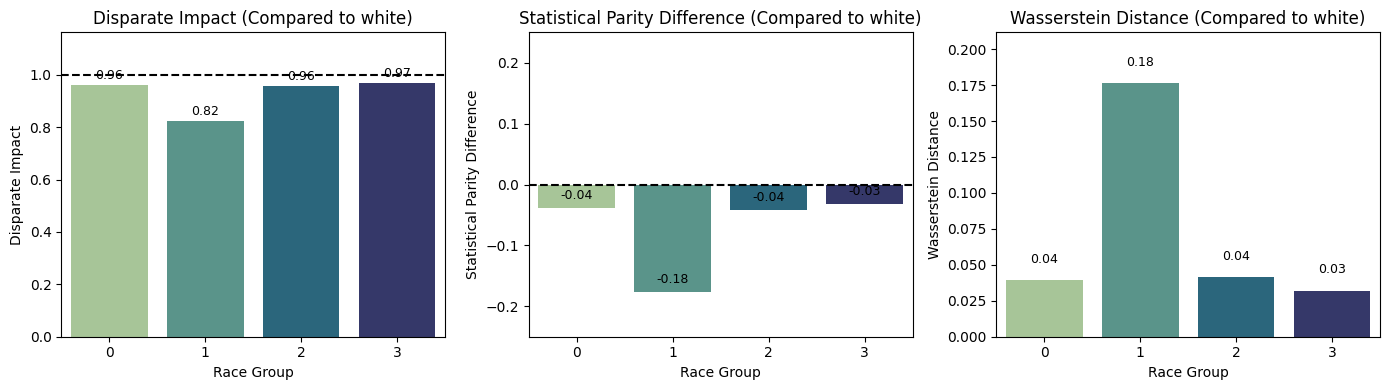

In [44]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_rw, 'race1_encoded', 4, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

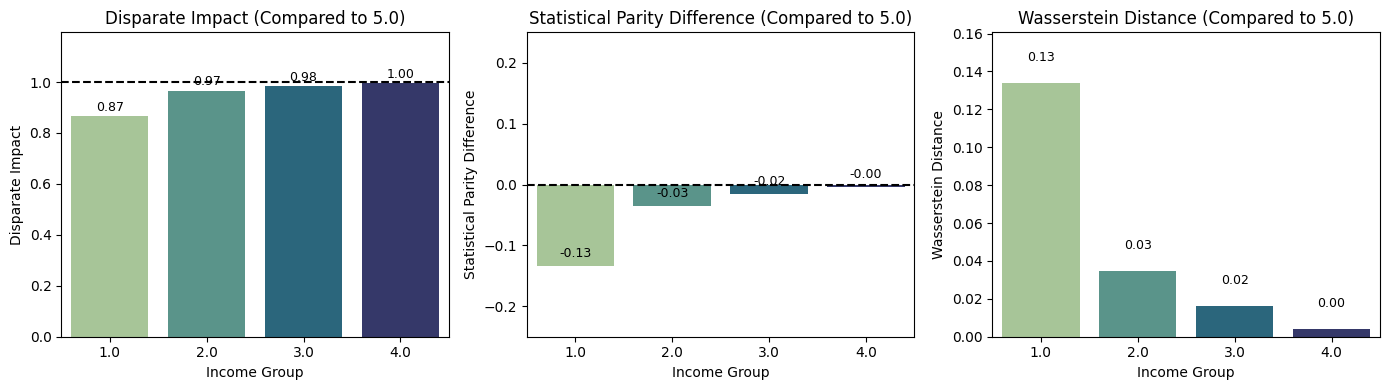

In [45]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_rw, 'fam_inc', 5.0, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

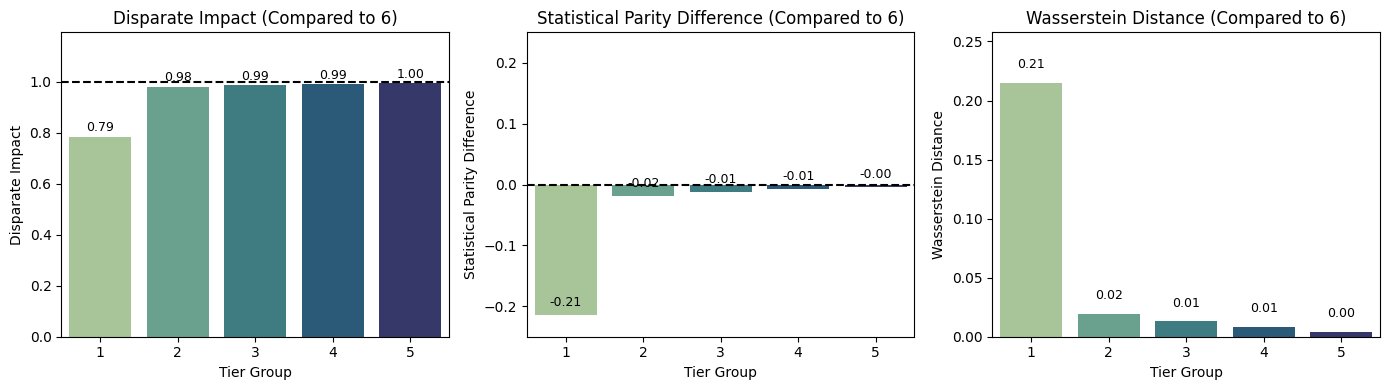

In [46]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_rw, 'tier', 6, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Tier Group', 6)